In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

In [2]:
def computeCI(data_list, alpha=0.05):
    '''
    This function computes the 100*(1-alpha)% Confidence Interval for the true mean based
    on n observations given a list.
    '''
    # Convert list to numpy array
    data = np.array(data_list)
    n = len(data)
    
    # Calculate mean and standard error
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # Sample std (using Bessel's correction with ddof=1)
    se = std / np.sqrt(n)
    
    # Calculate confidence interval using t-distribution
    df = n - 1
    t_critical = stats.t.ppf(1 - alpha/2, df)
    margin = t_critical * se
    
    return mean, margin

In [3]:
# eps = [0.125]
# eps = [2.0]
eps = [8.0]
# eps = [0.125, 2.0, 8.0]
N = [12,24,36,48,60,72,84,96,108,120]

In [4]:
# eps 0.125
benchmark_means = []
benchmark_margins = []
InitialModel_means = []
InitialModel_margins = []
OptimizedModel_means = []
OptimizedModel_margins = []
time0_means = []
time0_margins = []
for j in range(len(N)):
    benchmark_relativeOODerror = []
    InitialModel_relativeOODerror = []
    OptimizedModel_relativeOODerror = []
    time = []
    for k in range(10):
        df = pd.read_csv(f'training_log_eps{eps[0]}N{N[j]}/training_log_{k}.csv')
        benchmark_relativeOODerror.append(np.sqrt(df['Relative_Benchmark_OOD'][0]))
        InitialModel_relativeOODerror.append(np.sqrt(df['Relative_OOD_Error'][0]))
        OptimizedModel_relativeOODerror.append(np.sqrt(df['Relative_OOD_Error'].iloc[-1]))
        time.append(df['Time (s)'][1])
    benchmark_mean, benchmark_margin = computeCI(benchmark_relativeOODerror, alpha=0.05)
    InitialModel_mean, InitialModel_margin = computeCI(InitialModel_relativeOODerror, alpha=0.05)
    OptimizedModel_mean, OptimizedModel_margin = computeCI(OptimizedModel_relativeOODerror, alpha=0.05)
    time_mean, time_margin = computeCI(time, alpha=0.05)
    benchmark_means.append(benchmark_mean)
    benchmark_margins.append(benchmark_margin)
    InitialModel_means.append(InitialModel_mean)
    InitialModel_margins.append(InitialModel_margin)
    OptimizedModel_means.append(OptimizedModel_mean)
    OptimizedModel_margins.append(OptimizedModel_margin)
    time0_means.append(time_mean)
    time0_margins.append(time_margin)

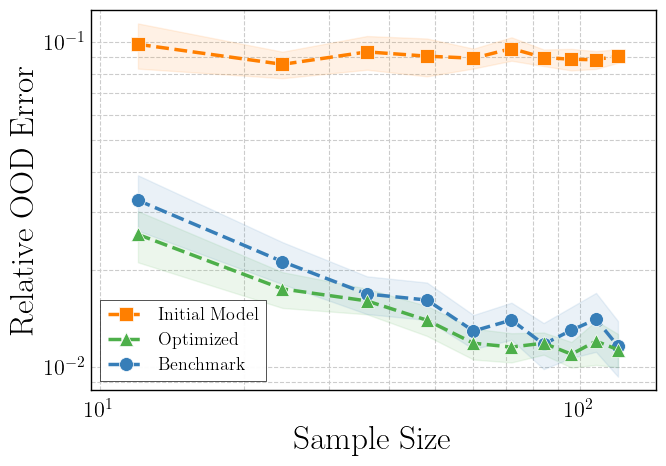

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 14
rcParams['figure.titlesize'] = 14
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.3
rcParams['axes.linewidth'] = 0.8
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = 'black'
rcParams['xtick.color'] = 'black'
rcParams['ytick.color'] = 'black'
rcParams['axes.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

# Convert to numpy arrays for easier manipulation
N_array = np.array(N)
benchmark_means_array = np.array(benchmark_means)
benchmark_margins_array = np.array(benchmark_margins)
InitialModel_means_array = np.array(InitialModel_means)
InitialModel_margins_array = np.array(InitialModel_margins)
OptimizedModel_means_array = np.array(OptimizedModel_means)
OptimizedModel_margins_array = np.array(OptimizedModel_margins)

colors = ['#377eb8', '#ff7f00', '#4daf4a']  # Blue, Orange, Green
alphas = [0.1, 0.1, 0.1]  # Transparency for confidence bands

# Initial Model
ax.loglog(N_array, InitialModel_means_array, 
          color=colors[1], linewidth=2.5,
          marker='s', markersize=10, markeredgewidth=0.5, markeredgecolor='white',
          label='Initial Model', zorder=3, linestyle='--')
ax.fill_between(N_array, 
                 InitialModel_means_array - InitialModel_margins_array,
                 InitialModel_means_array + InitialModel_margins_array,
                 color=colors[1], alpha=alphas[1], zorder=1)

# Optimized Model
ax.loglog(N_array, OptimizedModel_means_array, 
          color=colors[2], linewidth=2.5,
          marker='^', markersize=10, markeredgewidth=0.5, markeredgecolor='white',
          label='Optimized', zorder=3, linestyle='--')
ax.fill_between(N_array, 
                 OptimizedModel_means_array - OptimizedModel_margins_array,
                 OptimizedModel_means_array + OptimizedModel_margins_array,
                 color=colors[2], alpha=alphas[2], zorder=1)

# Benchmark
ax.loglog(N_array, benchmark_means_array, 
          color=colors[0], linewidth=2.5, 
          marker='o', markersize=10, markeredgewidth=0.5, markeredgecolor='white',
          label='Benchmark', zorder=2, linestyle='--')
ax.fill_between(N_array, 
                 benchmark_means_array - benchmark_margins_array,
                 benchmark_means_array + benchmark_margins_array,
                 color=colors[0], alpha=alphas[0], zorder=1)

ax.set_xlabel('Sample Size', fontweight='medium')
ax.set_ylabel('Relative OOD Error', fontweight='medium')

# Set y-axis limits with some padding (fixed the min/max calculation)
all_lower_bounds = np.concatenate([
    InitialModel_means_array - InitialModel_margins_array,
    OptimizedModel_means_array - OptimizedModel_margins_array,
    benchmark_means_array - benchmark_margins_array
])
all_upper_bounds = np.concatenate([
    InitialModel_means_array + InitialModel_margins_array,
    OptimizedModel_means_array + OptimizedModel_margins_array,
    benchmark_means_array + benchmark_margins_array
])

y_min = np.min(all_lower_bounds)
y_max = np.max(all_upper_bounds)
y_padding_factor = 1.1  # For log scale, use multiplicative padding
ax.set_ylim(y_min / y_padding_factor, y_max * y_padding_factor)

# Set x-axis limits with padding
ax.set_xlim(N[0] * 0.8, N[-1] * 1.2)

legend = ax.legend(loc='lower left', 
                   frameon=True, 
                   fancybox=False, 
                   shadow=False,
                   framealpha=0.95,
                   edgecolor='black',
                   ncol=1,
                   fontsize=13)
legend.get_frame().set_linewidth(0.5)

ax.grid(True, alpha=1, linestyle='--', which='both')  # Grid for both major and minor ticks
ax.spines['left'].set_edgecolor('black')
ax.set_axisbelow(True)

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_edgecolor('black')
ax.spines['right'].set_edgecolor('black')
ax.spines['top'].set_edgecolor('black')

# Get space between x axis exponents and x axis
ax.tick_params(axis='x', pad=8)

plt.tight_layout()

# Save the figure in high resolution
# Uncomment the following line to save the figure
# plt.savefig(f'Images/rte_eps{eps[0]}.png', dpi=300, bbox_inches='tight')

plt.show()